# **Generative Adversarial Networks(GANs)**
<img align='right' width='1000' src="https://cdn-images-1.medium.com/v2/resize:fit:851/0*pPEL7ryJR51VpnDO.jpg">

## **InfoGAN**
InfoGAN was introduced by researchers in 2016 to enhance the learning process of GANs by explicitly encouraging the model to learn disentangled and interpretable representations of the input data. The key idea behind InfoGAN is to maximize the mutual information between a subset of the latent variables (randomly sampled input to the generator) and the generated data. By doing so, InfoGAN aims to learn a more structured and meaningful representation of the input data.

In traditional GANs, the generator is provided with random noise as input, and it learns to map this noise to realistic-looking data. InfoGAN goes a step further by encouraging the generator to learn specific aspects or features of the data, making the generated representations more informative.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.distributions.normal import Normal

In [ ]:
# Hyperparameters
EPOCH = 20
Z_DIM = 100
LR = 2e-4
BS = 64
C, H, W = 1, 32, 32
NUM_CLASS = 10 # 0, 1, 2, ..., 9
EMBED_SIZE = 100
C_DIM = 2

c_criterion = lambda c_true, mean, logvar: Normal(mean, logvar.exp()).log_prob(c_true).mean()
criterion = nn.BCELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Availabe device is: ", device)

Availabe device is:  cuda


In [ ]:
# Visioalize the data
def show(tensor, ch=C, size=(H, W), num_to_display=16):
    """
    Inputs would be tensor with (batch_size, channel, height, weight) dimention
    First we detach() tensor so because it's not require grade any more,
    Then send it to cpu() to make sure the tensor doesn't on different device
    Matplotlib show images in (height, width, channel) dimention so the images permute to match the criteria
    """
    images = tensor.detach().cpu().view(-1, ch, *size)
    nrow=int(torch.sqrt(torch.tensor(num_to_display)))
    grid = make_grid(images[:num_to_display], nrow=nrow).permute(1, 2, 0)
    plt.axis(False)
    plt.imshow(grid)
    plt.show()

In [ ]:
def get_data(data=MNIST, bs=128):
    """
    From torchvision.datasets we can get different dataset
    for training GANs we don't need test datasets just trian sets will be enough
    """
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(H),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            [0.5 for _ in range(C)], [0.5 for _ in range(C)]
        )
    ])
    train_set = MNIST('.',
                      train=True,
                      transform=transform,
                      download=True)

    # group the data in different batch size
    data_loader = DataLoader(train_set, bs, shuffle=True)

    return data_loader

In [ ]:
data = get_data(MNIST, BS)
C, H, W = next(iter(data))[0][0].shape

## **Generator and Discriminator networks**

<img align='right' width='400' src='https://www.researchgate.net/publication/338979046/figure/fig5/AS:941759467114527@1601544362662/Architecture-of-InfoGAN-with-recognition-network-Q.png'>

&emsp;&emsp;The GAN formulation uses a simple factored continuous input noise vector z, while imposing no restrictions on the manner in which the generator may use this noise. As a result, it is possible that the noise will be used by the generator in a highly entangled way, causing the individual dimensions of z to not correspond to semantic features of the data [Ref](https://arxiv.org/abs/1606.03657).

&emsp;&emsp;provide control variables as input to the generator, along with the point in latent space (noise). The generator can be trained to use the control variables to influence specific properties of the generated images. This is the approach taken with the Information Maximizing Generative Adversarial Network, or **InfoGAN** for short. Simply somehow we try to **disentagled** the noise vecor

In [ ]:
#Generator
class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, hidden_ch=8, out_ch=C,
                 c_dim=C_DIM, img_size=H):
        super().__init__()
        self.img_size = img_size
        self.z_dim = z_dim
        # self.num_class = num_class
        self.gen = nn.Sequential(
            self._gen_block(z_dim + c_dim, hidden_ch*8, 4, 1, 0),
            self._gen_block(hidden_ch*8, hidden_ch*4, 4 , 2 , 1),
            self._gen_block(hidden_ch*4, hidden_ch*2, 4, 2, 1),
            nn.ConvTranspose2d(hidden_ch*2, out_ch, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, noise, c_labels):
        noise = torch.cat([noise, c_labels], dim=1)
        noise = noise.view(noise.shape[0], noise.shape[1], 1, 1)
        return self.gen(noise)

    def _gen_block(self, in_ch, out_ch, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_ch, out_ch, kernel, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

#Discriminator
class Critic(nn.Module):
    def __init__(self, img_ch=1, hidden_ch=8, out_dim=1, img_size=H, c_dim=C_DIM):
        super().__init__()
        self.img_size = img_size
        self.c_dim = c_dim
        self.initial = nn.Sequential(
            nn.Conv2d(img_ch, hidden_ch, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            self._disc_block(hidden_ch, hidden_ch*2, 4, 2, 1),
            self._disc_block(hidden_ch*2, hidden_ch*4, 4, 2, 1),
        )
        self.critic = nn.Sequential(
            self._disc_block(hidden_ch*4, hidden_ch*8, 4, 2, 1),
            nn.Flatten(),
            nn.Linear(hidden_ch * 8 * 2 * 2, out_dim),
            nn.Sigmoid()
        )

        self.auxiliary = nn.Sequential(
            self._disc_block(hidden_ch*4, hidden_ch*8, 4, 2, 1),
            self._disc_block(hidden_ch*8, c_dim * 2, 1, 2, 0),
        )


    def forward(self, x):
        x = self.initial(x)
        criti_out = self.critic(x).view(len(x), -1)
        Q_out = self.auxiliary(x).view(len(x), -1)
        q_mean, q_var = Q_out[:, :self.c_dim], Q_out[:, self.c_dim:]
        return criti_out, q_mean, q_var



    def _disc_block(self,in_ch, out_ch, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_ch, out_ch, kernel, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

gen_noise = lambda number, z_dim: torch.randn(number, z_dim).to(device)

## **Background**

- the minimax game in **Regular GANs** is given by the following expression:

<br>

$$
\begin{split}
    \large \underset{d}{\mathrm{min}} \underset{g}{\mathrm{max}} V(D, G) = \mathbb{E}_{\mathbb{𝐗} \sim P_{data}(x)} [\log{(D(𝐗))}] + \mathbb{E}_{\mathbb{z} \sim P_z(z)} [\log{(1-D(G(z)))}]
\end{split}
$$

<br>

The loss function of InfoGAN includes a term that maximizes the mutual information between a subset of the latent variables and the generated data. This encourages the generator to produce outputs where certain aspects are controlled and interpretable.The mutual information measures the amount of information that one random variable contains about another random variable. In the context of InfoGAN, the goal is to make sure that certain latent variables capture meaningful and interpretable aspects of the data being generated.

1. **Traditional GAN Loss $V(D, G)$:**

    - The traditional GAN loss consists of the generator and discriminator terms. The generator aims to minimize the probability that the discriminator correctly classifies generated samples as fake, while the discriminator aims to maximize this probability.

2. **Mutual Information Loss $I(c; G(z, c))$:**

    - InfoGAN introduces an additional term to the loss function that encourages the generator to learn specific features or attributes in a structured way. This is achieved by maximizing the mutual information between a subset of the latent variables (c) and the generated samples. Mathematically, this can be expressed as:

    - Here, c represents the subset of latent variables that InfoGAN aims to make informative, G is the generator function, z is the random noise, and I denotes mutual information. Maximizing this term encourages the generator to produce samples where the selected latent variables carry information about specific features.

3. **Combined Loss:**

    - The overall loss function for InfoGAN is a combination of the traditional GAN loss and the mutual information loss:

    - The hyperparameter lambda controls the trade-off between the traditional GAN objective and the mutual information maximization objective.


To encourage mutual information, this game is updated for $Q$ to maximize mutual information:

$$
    \large \displaystyle \min_{D} \max_{G, Q} V(D, G) - \lambda I(c; G(z, c))
$$

<br>

### **Mutual Information:**

1. **Mutual Information Definition:**
    - The mutual information between two random variables X and Y is defined as:
    - In the case of InfoGAN, X corresponds to the subset of latent variables c, and Y corresponds to the generated samples $G(z,c)$.

$$
    \large I(X; Y) = \sum_{\normalsize y \in \text{range}(Y)} \sum_{\normalsize x \in \text{range}(X)} p(x, y) \log\left(\frac{p(x, y)}{p(x)p(y)}\right)
$$

<br>

 2. **Entropy:**

    - For mutual information, we use the entropy to measure the uncertainty or randomness of the variables involved.
    - The entropy of a random variable X is defined as:

$$
    \large H(X) = -\sum_{\normalsize x \in \text{range}(X)} p(x) \log(p(x))
$$

<br>

3. **Mutual Information Simplification:**
    - In practice, mutual information can be simplified using the properties of entropy. The mutual information between X and Y can be expressed as:
    - - Here, $H(X)$ is the entropy of X, and $H(X∣Y)$ is the conditional entropy of X given Y.

$$
    \large I(X; Y) = H(X) - H(X|Y)
$$

<br>

4. **InfoGAN Mutual Information Loss:*
    - In the case of InfoGAN, the mutual information loss is expressed as:

$$
    \large \mathcal{L}_{\text{info}} = H(c) - H(c | G(z, c))
$$

<br>

The goal is to maximize $\mathcal{L}_{\text{info}}$, which encourages the generator to produce samples where the entropy of the subset of latent variables c is reduced, indicating that these variables carry meaningful and specific information about the generated data.

<br>

$$
\begin{split}
    I(c; G(z, c)) & = H(c) - H(c|G(z, c)) \\
    & = {\mathbb{E}}_{x \sim G(z, c)} [ {\mathbb{E}}_{c' \sim P(c, x)} \log P(c' | x) ] + H(c) \textit{ (by definition of H)}\\
    & = {\mathbb{E}}_{x \sim G(z, c)} [\Delta + {\mathbb{E}}_{c' \sim P(c, x)} \log Q(c' | x) ] + H(c) \textit{ (approximation error)}\\
    & \geq {\mathbb{E}}_{x \sim G(z, c)} [{\mathbb{E}}_{c' \sim P(c, x)} \log Q(c' | x) ] + H(c) \textit{ (KL divergence is non-negative)}\\
\end{split}
$$

In [ ]:
#This the the most important part of the training
def gen_MSEloss_func(gen_net, critic_net, c_criterion,
                     batch_size, z_dim, c_dim=C_DIM, mode=1):
    """
    mode = 1 --> Generating samples as real as possible
    mode = 2 --> Minimizing Pearson X² divergence
    """
    noise = gen_noise(batch_size, z_dim)
    c_labels = gen_noise(batch_size, c_dim)
    fake = gen_net(noise, c_labels)

    pred, q_mean, q_logvar = critic_net(fake)
    mutual_information = c_criterion(c_labels, q_mean, q_logvar)

    c = 1 if mode == 1 else 0
    return 0.5 * torch.sum((pred - c) ** 2) - 0.1 * torch.sum(mutual_information)


def critic_MSEloss_func(gen_net, critic_net, c_criterion,
                        image, batch_size, z_dim, c_dim=C_DIM, mode=1):
    noise = gen_noise(batch_size, z_dim)
    c_labels = gen_noise(batch_size, c_dim)
    fake = gen_net(noise, c_labels)

    fake_pred, q_mean, q_logvar = critic_net(fake.detach()) # detach() the generator output so it won't participate in gen_net learning
    mutual_information = c_criterion(c_labels, q_mean, q_logvar)
    real_pred, _, _ = critic_net(image)

    b, a = (1, 0) if mode == 1 else (1, -1)
    loss = 0.5 * torch.sum(((real_pred - b) ** 2 )+ ((fake_pred - a) ** 2)) \
    - 0.1 * torch.sum(mutual_information)
    return loss

In [ ]:
#This the the most important part of the training
def gen_loss_func(gen_net, critic_net, criterion,
                  c_criterion, batch_size, z_dim, c_dim=C_DIM):
    noise = gen_noise(batch_size, z_dim)
    c_labels = gen_noise(batch_size, c_dim)
    fake = gen_net(noise, c_labels)

    pred, q_mean, q_logvar = critic_net(fake)
    mutual_information = c_criterion(c_labels, q_mean, q_logvar)

    return criterion(pred, torch.ones_like(pred)) - 0.1 * mutual_information


def critic_loss_func(gen_net, critic_net, criterion, c_criterion,
                        image, batch_size, z_dim, c_dim=C_DIM):
    noise = gen_noise(batch_size, z_dim)
    c_labels = gen_noise(batch_size, c_dim)
    fake = gen_net(noise, c_labels)

    fake_pred, q_mean, q_logvar = critic_net(fake.detach()) # detach() the generator output so it won't participate in gen_net learning
    mutual_information = c_criterion(c_labels, q_mean, q_logvar)
    real_pred, _, _ = critic_net(image)

    disc_fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
    disc_real_loss = criterion(real_pred, torch.ones_like(real_pred))

    return (disc_fake_loss + disc_real_loss) / 2 - 0.1 * mutual_information

In [ ]:
from torch.utils.tensorboard import SummaryWriter
!rm -r /content/runs
writer = SummaryWriter("/content/runs")
writer_fake = SummaryWriter("/content/runs/fake")
writer_real = SummaryWriter("/content/runs/real")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs
%reload_ext tensorboard

In [ ]:
!rm -r $PATH
PATH = "/content/model/"
!mkdir $PATH

In [ ]:
gen = Generator().to(device)
gen.apply(weights_init)
# gen.load_state_dict(torch.load('/content/Gen_20'))
gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-3, betas=(0.5, 0.999))
gen_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt, step_size=2, gamma=1)

critic = Critic().to(device)
critic.apply(weights_init)
# critic.load_state_dict(torch.load('/content/Critic_20'))
critic_opt = torch.optim.Adam(critic.parameters(), lr=2e-4, betas=(0.5, 0.999))
critic_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(critic_opt, step_size=2, gamma=1)

In [ ]:
step = 0
for epoch in range(EPOCH):
    criticLoss, genLoss = 0, 0
    print(f"\nEpoch: {epoch + 1}")

    for batch,  (real, _) in enumerate(tqdm(data)):
        real = real.to(device)
        # LOSS function in the paper
        critic_loss = critic_loss_func(gen, critic, criterion,
                                       c_criterion, real, len(real), Z_DIM, C_DIM)
        # Use least square methos which is not good
        # critic_loss = critic_MSEloss_func(gen, critic, c_criterion, real, len(real), Z_DIM, C_DIM)

        critic_opt.zero_grad()
        critic_loss.backward(retain_graph=True) # If False, the graph used to compute the grad will be freed, Actually It isnt necessary
        critic_opt.step()

        # LOSS function in the paper
        gen_loss = gen_loss_func(gen, critic, criterion,
                                 c_criterion, len(real), Z_DIM, C_DIM)
        # Use least square methos which is not good
        # gen_loss = gen_MSEloss_func(gen, critic, c_criterion, len(real), Z_DIM, C_DIM)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

        criticLoss += critic_loss /len(data)
        genLoss += gen_loss /len(data)
        if batch % 150 == 0 and batch != 0:
            with torch.no_grad():
                step += 1
                fake = gen(gen_noise(BS, Z_DIM), gen_noise(BS, C_DIM)).view(-1, C, H, W)
                image = real.view(-1, C, H, W)
                real_grid = make_grid(image[:32], normalize=True)
                fake_grid = make_grid(fake[:32], normalize=True)

                writer_fake.add_image(
                    "MNIST fake image", fake_grid, global_step=step
                )
                writer_real.add_image(
                    "MNIST real image", real_grid, global_step=step
                )

        writer.add_scalars("Loss", {
                    "Critic": critic_loss,
                    "Generator": gen_loss
                }, (epoch+1)*batch)

    print(f'  Critic Loss: {criticLoss:.4f} -- Generator Loss: {genLoss:.4f}')
    gen_exp_lr_scheduler.step()
    critic_exp_lr_scheduler.step()

    #Save model
    torch.save(gen.state_dict(), f"{PATH}Gen_{epoch+1}")
    torch.save(critic.state_dict(), f"{PATH}Critic_{epoch+1}")


    if (epoch + 1) % 2 == 0 and epoch > 0:
        print(f"  >>> Critic Learning Rate: {critic_opt.param_groups[0]['lr']}")
        print(f"  >>> Generator Learning Rate: {gen_opt.param_groups[0]['lr']}")

In [ ]:
# gen.load_state_dict(torch.load('/content/model/Gen_14'))
# fake = gen(gen_noise(BS, Z_DIM), gen_noise(BS, C_DIM)).view(-1, C, H, W)
# show(fake)

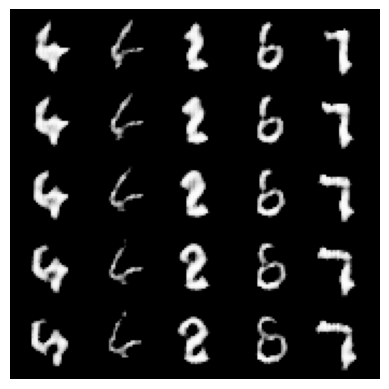

In [ ]:
import math

gen = gen.eval()
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)

def interpolate_class(n_view=5):
    interpolation_noise = gen_noise(n_view, Z_DIM).repeat(n_interpolation, 1)
    first_label = gen_noise(1, C_DIM).repeat(n_view, 1)[None, :]
    second_label = first_label.clone()
    first_label[:, :, 0] =  -2
    second_label[:, :, 0] =  2


    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation).to(device)[:, None, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label
    interpolation_labels = interpolation_labels.view(-1, C_DIM)

    fake = gen(interpolation_noise, interpolation_labels)
    show(fake, num_to_display=25)

interpolate_class()

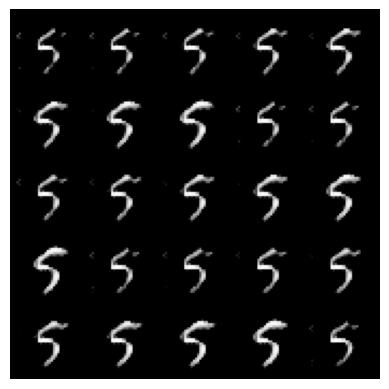

In [ ]:
import math

### Change me! ###
n_interpolation = 8 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)

def interpolate_class():
    interpolation_noise = gen_noise(1, Z_DIM).repeat(n_interpolation * n_interpolation, 1)
    first_label = gen_noise(1, C_DIM).repeat(n_interpolation * n_interpolation, 1)

    # Calculate the interpolation vector between the two labels
    first_label = torch.linspace(-2, 2, n_interpolation).repeat(n_interpolation).to(device)
    second_label = torch.linspace(-2, 2, n_interpolation).repeat_interleave(n_interpolation).to(device)
    interpolation_labels = torch.stack([first_label, second_label], dim=1)

    fake = gen(interpolation_noise, interpolation_labels)
    show(fake, num_to_display=25)

interpolate_class()